<a href="https://colab.research.google.com/github/RyanZR/ColabDock-Vina/blob/main/ColabDock_Vina_(SD).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **🍊 ColabDock Vina** (Single Docking)
This project is created based on [Lab.06 / IBM3202 – Molecular Docking on AutoDock](https://colab.research.google.com/github/pb3lab/ibm3202/blob/master/tutorials/lab06_docking.ipynb#scrollTo=WutUwTFo2e4j). It provide more dynamic options for visulisation and docking. All credits goes to the author of the mentioned jupiter notebook. 

---
---
# **Setting the Environment for Molecular Docking**

Before starting, we need to install all the necessary software and dependecies to perform molecular docking. 

+ condacolab (https://github.com/conda-incubator/condacolab)
+ MGLtools (https://ccsb.scripps.edu/mgltools/)
+ AutoDock Vina (https://vina.scripps.edu/)
+ biopython (https://biopython.org/)
+ OpenBabel (https://github.com/openbabel/openbabel)
+ py3Dmol (https://pypi.org/project/py3Dmol/)

In [1]:
# @title **Install dependencies and softwares**
# @markdown It will take a few minutes. It will **restart** after the installation. 

%%capture
# Delete sample data
!rm -r /content/sample_data > /dev/null 2>&1

# Install dependencies
!pip install py3Dmol > /dev/null 2>&1
!pip install pybel > /dev/null 2>&1
!pip install rdkit-pypi > /dev/null 2>&1

# Setup AutoDock Vina
!wget -qnc https://vina.scripps.edu/wp-content/uploads/sites/55/2020/12/autodock_vina_1_1_2_linux_x86.tgz > /dev/null 2>&1
!tar xzvf autodock_vina_1_1_2_linux_x86.tgz > /dev/null 2>&1
!rm autodock_vina_1_1_2_linux_x86.tgz -f > /dev/null 2>&1

# Setup Conda
!pip install -q condacolab
import condacolab
condacolab.install_miniconda()

# Install other packages
!conda install -c conda-forge -c bioconda mgltools=1.5.7 biopython=1.78 openbabel=2.4.1 zlib=1.2.11 xlsxwriter --yes > /dev/null 2>&1
!rm /content/condacolab_install.log > /dev/null 2>&1

In [1]:
# @title **Import Python modules**
# @markdown This allow Python accessible to the neccessary modules.

# Import modules
import os
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

import shutil
import py3Dmol
import math
import pybel
import xlsxwriter
import numpy as np
import pandas as pd
import seaborn as sns
import urllib.request
import matplotlib.pyplot as plt

from Bio.PDB import *
from pathlib import Path
from google.colab import drive,files
import ipywidgets as widgets

from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display

from rdkit import Chem
from rdkit.Chem import rdFMCS,AllChem,Draw,PandasTools
from rdkit.Chem.Draw import DrawingOptions,IPythonConsole

import ipywidgets
from ipywidgets import interact


%matplotlib inline

# Capture python output
class Hide:
  def __enter__(self):
    self._original_stdout = sys.stdout
    sys.stdout = open(os.devnull, "w")
  
  def __exit__(self, exc_type, exc_val, exc_tb):
    sys.stdout.close()
    sys.stdout = self._original_stdout

# Define common variables
colors = ["red","orange","yellow","lime","green","cyan","teal","blue","violet","purple","pink","gray","brown","white","black"] 
io = PDBIO()
parser = PDBParser()

print("> Installation done")
print("> Import done")
print("> Environment ready for docking")

> Installation done
> Import done
> Environment ready for docking


In [2]:
# @title **Setup alias for Vina**
# @markdown This create an alias for AutoDock Vina.

# Setup alias for Vina
%alias vina /content/autodock_vina_1_1_2_linux_x86/bin/vina
%alias vina_split /content/autodock_vina_1_1_2_linux_x86/bin/vina_split

print("> Alias '%Vina' created")
print("> Alias '%Vina_split' created")

> Alias '%Vina' created
> Alias '%Vina_split' created


In [3]:
# @title **Create folders**
# @markdown Enter a **Jobname** without space. This create a folder for protein, ligand, experimental and docking.

# Define path of folder
Jobname = "7KNX_docking" #@param {type: "string"}
dir = os.path.abspath(".")
work_dir = os.path.join(dir,Jobname)
protein_folder = os.path.join(work_dir,"protein")
ligand_folder = os.path.join(work_dir,"ligand")
experimental_folder = os.path.join(work_dir,"experimental")
docking_folder = os.path.join(work_dir,"docking")

# Create folder if folder have not exists
folder = [work_dir,protein_folder,ligand_folder,experimental_folder,docking_folder]
for f in folder:
  if os.path.exists(f):
    print("> %s already exists" % f)
  if not os.path.exists(f):
    os.mkdir(f)
    print("> %s was successfully created" % f)

> /content/7KNX_docking was successfully created
> /content/7KNX_docking/protein was successfully created
> /content/7KNX_docking/ligand was successfully created
> /content/7KNX_docking/experimental was successfully created
> /content/7KNX_docking/docking was successfully created


---
---
# **Preparing the Protein**

The first step in docking is to have a structure of a given targer protein. While in some cases a high-quality comparative model will be used, most cases start with an experimentally (X-ray, NMR, cryoEM) solved three-dimensional structure. 

In such cases, a given target protein structure can be downloaded from the [Protein Data Bank (PDB)](https://www.rcsb.org/pdb) using a given accession ID.  We can directly download this structure in `.pdb` file format.

In [4]:
# @title **Generate protein PDB file**
# @markdown Enter PDB accession ID to download targeted protein.

# Define variables
PDB_ID = "7KNX" # @param {type:"string"}
protein = PDB_ID
protein_pdb = protein + ".pdb"
protein_prot = protein + "_prot"
protein_prot_pdb = protein_prot + ".pdb"
protein_pdb_pfile = os.path.join(protein_folder,protein_pdb)
protein_prot_pfile = os.path.join(protein_folder,protein_prot)
protein_prot_pdb_pfile = os.path.join(protein_folder,protein_prot_pdb)

# Download the protein pdb file
urllib.request.urlretrieve("http://files.rcsb.org/download/" + protein_pdb, protein_pdb_pfile)

print("> " + protein + ".pdb" + " successfully created in " + protein_folder)

> 7KNX.pdb successfully created in /content/7KNX_docking/protein


In [5]:
# @title **Extract protein**
# @markdown This extract **amino acids** from protein pdb file downloaded. In term of file structure, the **ATOM** lines will be extracted into a new file. Protein subunits will also be extracted as their own separate file.

# Write lines that contain #string "ATOM" into a new file
with open(protein_prot_pdb_pfile,"w") as g:
  f = open(protein_pdb_pfile,"r")
  for line in f:
    row = line.split()
    if row[0] == "ATOM":
      g.write(line)
  print("> Protein extracted")
print("> " + protein_prot_pdb + " successfully created in " + protein_folder)

# Separate protein subunits
def separate_protein(input):
  structure  = parser.get_structure("X", input)
  chainList = [chain for chain in structure.get_chains()]
  chainLen = len(chainList)
  print("> %s of subunit(s) detected" % chainLen)
  if chainLen > 1:
    for chain in chainList:
      io.set_structure(chain)
      io.save(protein_prot_pfile + "_" + chain.get_id() + ".pdb")
      print("> " + protein_prot + "_%s.pdb successfuly created in " % chain.get_id() + protein_folder)

separate_protein(protein_prot_pdb_pfile)

> Protein extracted
> 7KNX_prot.pdb successfully created in /content/7KNX_docking/protein
> 4 of subunit(s) detected
> 7KNX_prot_A.pdb successfuly created in /content/7KNX_docking/protein
> 7KNX_prot_B.pdb successfuly created in /content/7KNX_docking/protein
> 7KNX_prot_C.pdb successfuly created in /content/7KNX_docking/protein
> 7KNX_prot_D.pdb successfuly created in /content/7KNX_docking/protein


In [126]:
# @title **Setup 3D structure viewer**
# @markdown This create 3D viewer for the tertiary protein structure.

# Setup different viewing options
def chain_check(input):
  chainId = []
  structure  = parser.get_structure("X",input)
  numberOfChain = len(list(structure.get_chains()))
  return numberOfChain

def add_bs(object,count):
  object.addStyle(
      {"model":count},
      {"stick":{"colorscheme":"whiteCarbon"}})

def add_line(object,count):
  object.addStyle(
      {"model":count},
      {"line":{"colorscheme":"whiteCarbon"}}) 

def show_subunits(object,input,count):
  j = chain_check(input)
  if j > 1:
    for n,m in zip(range(j),colors):
      object.setStyle(
          {"and":[{"model":count},{"chain":(chr(65+n))}]},
          {style:{types:(m if style == "cartoon" else m + "Carbon")}})
      object.addLabel(
          "Subunit " + chr(65+n),
          {"fontColor":m,"backgroundOpacity": 0.7,"alignment":"topLeft"},
          {"and":[{"model":count},{"chain":(chr(65+n))}]})

def show_res(object,res,count,highlight):
  res = res.split(",")
  object.addStyle(
      {"and":[{"model":count},{"resi": res}]},
      {"stick":{"colorscheme":highlight + "Carbon"}})
  object.addResLabels(
      {"and":[{"model":count},{"resi": res}]},
      {"backgroundOpacity": 0.7,"fontColor":highlight,"inFront":False})

def show_all_res(object,count):
  object.addResLabels(
      {"and":[{"model":count},{"resi": "1-9999999"}]},
      {"backgroundOpacity":0.7,"inFront":False})

def show_vdw_surface(object,count):
  object.addSurface(
      py3Dmol.VDW,
      {"color":"white","opacity":0.6},
      {"model":count})

# Setup 3D viewer
def view_prot(input, 
              style = "cartoon",
              types = "color",
              color = "white",
              highlight = "white",
              showSubunit = False,
              addBS = False,
              addLine = False,
              showRes = "",
              showAllRes = False,
              showVDWsurface = False):
  print("> " + "Showing " + input[len(protein_folder)+1:] + " ...")
  print("")
  count = 0
  mview = py3Dmol.view(1000,1400)
  mview.setViewStyle({'style':'outline','color':'black','width':0.1})
  mol = open(input,"r").read()
  mview.addModel(mol,"pdb")
  count += 1
  mview.setStyle(
      {"model":count},
      {style:{types:color,"style":"oval"}})
  if showSubunit: 
    show_subunits(mview,input,count) 
  if addBS:
    add_bs(mview,count) 
  if addLine:
    add_line(mview,count) 
  if showRes != "":
    show_res(mview,showRes,count,highlight,count) 
  if showAllRes:
    show_all_res(mview,count)
  if showVDWsurface:
    show_vdw_surface(mview,count)
  mview.setBackgroundColor("0xFFFFFF")
  mview.zoomTo()
  mview.show()

print("> 3D structure viewer created")

> 3D structure viewer created


In [127]:
# @title **Display 3D protein** { run: "auto" }
# @markdown Enter the protein to be viewed.

# Define variable
View = "7KNX_prot_A.pdb" #@param {type:"string"}
Model = "Ribbon Model" #@param ["None","Line Model","Stick Model", "Ribbon Model"]
Model_colour = "white" #@param ["red","orange","yellow","green","blue","violet","purple","white","spectrum"]
View_residues = "" #@param {type:"string"}
Residues_colour = "yellow" #@param ["red","orange","yellow","green","blue","violet","purple","white"]
Show_all_residues = False #@param {type:"boolean"}
Show_all_subunits = False #@param {type:"boolean"}
Show_VDW_surface = True #@param {type:"boolean"}
Add_stick_model = False #@param {type:"boolean"}
Add_line_model = False #@param {type:"boolean"}
style = ""
types = ""
color = ""
view_pfile = os.path.join(protein_folder,View)

# Define model
if Model == "None":
  style = ""
  types = ""
if Model == "Line Model":
  style = "line"
  types = "colorscheme"
if Model == "Stick Model":
  style = "stick"
  types = "colorscheme"
if Model == "Ribbon Model":
  style = "cartoon"
  types = "color"
  
# Display 3D structure
@interact
def viewer_one():
  try:
    view_prot(input = view_pfile, 
              style = style,
              types = types,
              color = Model_colour,
              highlight = Residues_colour,
              showSubunit = Show_all_subunits,
              addBS = Add_stick_model,
              addLine = Add_line_model,
              showRes = View_residues,
              showAllRes = Show_all_residues,
              showVDWsurface = Show_VDW_surface)
  except Exception as e:
    print(e)

interactive(children=(Output(),), _dom_classes=('widget-interact',))

In [48]:
# @title **Parameterise protein with Gasteiger charges** 
# @markdown Enter the protein to be parameterised. This add polar hydrogen to the protein and parameterise it with Gasteiger charge using MGLtools. The protein will be converted to **pdbqt** file. In addition, this also fixes the OpenBabel out-of-format conversion bug.

# Define variables
Target_protein = "7KNX_prot_A.pdb" #@param {type:"string"}
PROTEIN = os.path.splitext(Target_protein)[0]
PROTEIN_pdb = PROTEIN + ".pdb"
PROTEIN_pdbqt = PROTEIN + ".pdbqt"
PROTEIN_pre_pdbqt = PROTEIN + "_pre.pdbqt"
PROTEIN_pdb_pfile = os.path.join(protein_folder,PROTEIN_pdb)
PROTEIN_pdb_dfile = os.path.join(docking_folder,PROTEIN_pdb)
PROTEIN_pdbqt_dfile = os.path.join(docking_folder,PROTEIN_pdbqt)

# Add polar hydrogen and parameterise with MGLtools
with Hide():
  !prepare_receptor4.py -r $PROTEIN_pdb_pfile -o $PROTEIN_pdbqt_dfile -A hydrogens -U nphs_lps -v
shutil.copy(PROTEIN_pdb_pfile,docking_folder)

print("> " + PROTEIN_pdbqt + " successfully created in " + docking_folder)

> 7KNX_prot_A.pdbqt successfully created in /content/7KNX_docking/docking


---
---
# **Preparing the Experimental Ligand**
We can compare the docking poses for verification with the experimentally solved pose for the ligand. This step is **optional**.

In [53]:
# @title **Generate experimental ligand PDB file**
# @markdown Enter the **name** assigned for the experimental ligand. 

# Defines variables
Experimental_ligand_name = "QOV" #@param {type:"string"}
eln = Experimental_ligand_name
eln_pdb = eln + ".pdb"
eln_efile = os.path.join(experimental_folder,eln)
eln_pdb_efile = os.path.join(experimental_folder,eln_pdb)

# Extract exp_ligand
with open(eln_pdb_efile,"w") as g:
  f = open(protein_pdb_pfile,"r")
  for line in f:
    row = line.split()
    if eln in row:
      g.write(line)
  print("> Experimental ligands extracted")

print("> " + eln_pdb + " successfully created in " + experimental_folder)

> Experimental ligands extracted
> QOV.pdb successfully created in /content/7KNX_docking/experimental


In [54]:
# @title **Extract experimental ligands**
# @markdown This extract all the **experimental ligands** from the pdb file and export it as separate files if any.

# Separate different experimental ligandsz
def separate_exp(input):
  structure  = parser.get_structure("X", input)
  chainList = [chain for chain in structure.get_chains()]
  chainLen = len(chainList)
  print("> %s ligands(s) detected" % chainLen)
  if chainLen > 1:
    for chain in chainList:
      io.set_structure(chain)
      io.save(eln_efile + "_" + chain.get_id() + ".pdb")
      print("> " + eln + "_%s.pdb successfuly created in " % chain.get_id() + experimental_folder)
separate_exp(eln_pdb_efile)

> 4 ligands(s) detected
> QOV_A.pdb successfuly created in /content/7KNX_docking/experimental
> QOV_B.pdb successfuly created in /content/7KNX_docking/experimental
> QOV_C.pdb successfuly created in /content/7KNX_docking/experimental
> QOV_D.pdb successfuly created in /content/7KNX_docking/experimental


In [109]:
# @title **Setup 3D structure viewer**
# @markdown This create 3D viewer for experimental ligand.

def show_atoms(object,count):
  object.addPropertyLabels("atom",{"model":count},{"fontSize":12,"backgroundOpacity":0.7,"inFront":True})

# Setup 3D viewer
def view_eln(input,showAtom):
  print("> " + "Showing " + input[len(experimental_folder)+1:] + " ...")
  print("")
  count = 0
  mview = py3Dmol.view(1000,1400)
  mview.setViewStyle({'style':'outline','color':'black','width':0.1})
  mol = open(input,"r").read()
  mview.addModel(mol,"pdb")
  count += 1
  mview.setStyle(
      {"model":count},
      {"stick":{"colorscheme":"lightGrayCarbon"}})
  if showAtom:
    show_atoms(mview,count)
  mview.setBackgroundColor("0xFFFFFF")
  mview.zoomTo()
  mview.show()

In [118]:
# @title **Display 3D ligand** {run: "auto"}
# @markdown This display experimental docked ligand in 3D space.

# Define variables
View_exp_lig = "QOV_A.pdb" #@param {type:"string"}
Show_atoms = True #@param {type:"boolean"}
view_efile = os.path.join(experimental_folder,View_exp_lig)

# Display 3D structure
@interact
def viewer_two():
  try:
    view_eln(input = view_efile,
             showAtom = Show_atoms)
  except Exception as e:
    print(e)

interactive(children=(Output(),), _dom_classes=('widget-interact',))

In [61]:
# @title **Choose exprimental model**
# @markdown Enter a target experimental ligand for comparison.

# Define variables
Target_exp = "QOV_A.pdb" #@param {type:"string"}
EXP = Target_exp[:-4]
EXP_pdb = EXP + ".pdb"
EXP_mol2 = EXP + ".mol2"
EXP_pdb_efile = os.path.join(experimental_folder,EXP_pdb)
EXP_pdb_dfile = os.path.join(docking_folder,EXP_pdb)
EXP_mol2_dfile = os.path.join(docking_folder,EXP_mol2)

# Copy file to docking_folder
shutil.copy(EXP_pdb_efile,docking_folder)
print("> " + EXP_pdb + " successfully created in " + docking_folder)

> QOV_A.pdb successfully created in /content/7KNX_docking/docking


---
---
# **Preparing the Ligand**

We now need to prepare the ligand that will be used for docking analysis. We will attempt to predict the docking pose onto the binding of target protein.

In [64]:
# @title **Generate ligand SMILES file**
# @markdown Enter the **canonical** SMILES of ligand.

# Define variables
Ligand_name = "C26A6" #@param {type:"string"}
SMILES = "CC1=NN2C=CC=C(C2=N1)NS(=O)(=O)C3=C(C=CC(=C3)Cl)OC" #@param {type:"string"}
LIGAND = Ligand_name
LIGAND_smi = LIGAND + ".smi"
LIGAND_mol2 = LIGAND + ".mol2"
LIGAND_pdbqt = LIGAND + ".pdbqt"
LIGAND_dock = LIGAND + "_"
LIGAND_smi_lfile = os.path.join(ligand_folder,LIGAND_smi)
LIGAND_mol2_lfile = os.path.join(ligand_folder,LIGAND_mol2)
LIGAND_pdbqt_dfile = os.path.join(docking_folder,LIGAND_pdbqt)
LIGAND_dock_dfile = os.path.join(docking_folder,LIGAND_dock)

# Generate files
with open(LIGAND_smi_lfile, "w") as g:
  g.write(SMILES)

print("> " + LIGAND_smi + " successfully created in " + ligand_folder)

> C26A6.smi successfully created in /content/7KNX_docking/ligand


In [111]:
# @title **Setup 3D structure viewer**
# @markdown This create 3D viewer for ligand with 10000 iterations of energy minimisation via MMFF.

# Setup 3D viewer
def view_lig(input,showAtom=False):
  print("> " + "Showing " + LIGAND + ".smi ...")
  print("")
  count = 0
  mview = py3Dmol.view(1000,1400)
  mview.setViewStyle({'style':'outline','color':'black','width':0.1})
  mol = open(input,"r").read()
  count += 1
  mblock = Chem.MolFromSmiles(mol) # Convert smi to mol
  mblock = Chem.AddHs(mblock)
  mstatus = AllChem.EmbedMolecule(mblock)
  mstatus = AllChem.MMFFOptimizeMolecule(mblock,maxIters=10000)
  mblock = Chem.MolToMolBlock(mblock)
  mview.addModel(mblock, "mol")
  mview.setStyle(
      {"model":count},
      {"stick":{"colorscheme":"lightGrayCarbon"}})
  if showAtom:
    show_atoms(mview,count)
  mview.setBackgroundColor("0xFFFFFF")
  mview.zoomTo()
  mview.show()

print("> 3D structure viewer created")

> 3D structure viewer created


In [117]:
# @title **Display 3D ligand** {run: "auto"}
# @markdown This display molecular dynamic-optimised ligand in 3D space.

# Define variables
Show_atoms = False #@param {type:"boolean"}

# Display 3D structure
@interact
def viewer_three():
  try:
    view_lig(input = LIGAND_smi_lfile,
             showAtom = Show_atoms)
  except Exception as e:
    print(e)

interactive(children=(Output(),), _dom_classes=('widget-interact',))

In [72]:
# @title **Parameterize ligand with Gasteiger charges**
# @markdown This convert **SMILES** to **mol2** file while simultaneously performing energy minimization using **`Universal Force Field (UFF)`** at 10000 iterations. After that, this add polar hydrogen to the protein and parameterise it with Gasteiger charge using MGLtools. The ligand will be converted to **pdbqt** file.

# Convert from SMILES into a 3D mol2 and pdb format
# Perform energy minimization using the GAFF(Amber)
with Hide():
  !obabel $LIGAND_smi_lfile -O $LIGAND_mol2 --gen3d --best --canonical --minimize --ff UFF --steps 10000 --sd

# Add polar hydrogen and parameterise with MGLtools
# Add -z leads to a rigid ligand without any torsions
# There something wrong with MGLtools that it does not recognise the input mol2 file put in ligand folder
# Have to do another way by performing convertion in /content/ and moving mol2 file back to ligand folder
with Hide():
  !prepare_ligand4.py -l $LIGAND_mol2 -o $LIGAND_pdbqt_dfile -U nphs_lps -v
shutil.move(LIGAND_mol2,ligand_folder)

print("> " + LIGAND_smi + " successfully converted to " + LIGAND_mol2)
print("> " + LIGAND_mol2 + " successfully converted to " + LIGAND_pdbqt + " in " + docking_folder)

> C26A6.smi successfully converted to C26A6.mol2
> C26A6.mol2 successfully converted to C26A6.pdbqt in /content/7KNX_docking/docking


---
---
# **Setting Up Molecular Docking**
It is necessary to define search space for docking on a target protein through the use of grid box. The grid box is usually centered within the binding, active or allosteric site of target protein and its size should be sufficiently enough such that important binding residues are contained inside the box.

In [114]:
# @title **Setup gridbox** 
# @markdown Click once to create gridbox with 3D protein structure.

# Define the grid box
def define_grid(object,bxi,byi,bzi,bxf,byf,bzf):
  object.addBox({"center":{"x":bxi,"y":byi,"z":bzi},"dimensions": {"w":bxf,"h":byf,"d":bzf},"color":"blue","opacity": 0.6})

# Generate 3D protein docking viewer
def view_dock_grid(input,showRes,bxi,byi,bzi,bxf=10,byf=10,bzf=10):
  print("> " + "Showing " + input[len(docking_folder)+1:] + " ...")
  print("")
  count = 0
  mview = py3Dmol.view(1000,1500)
  mview.setViewStyle({'style':'outline','color':'black','width':0.1})
  mol = open(input, "r").read()
  mview.addModel(mol,"pdb")
  count += 1
  define_grid(mview,bxi,byi,bzi,bxf,byf,bzf)
  mview.setStyle(
      {"model":count},
      {"cartoon":{"color":"spectrum","style":"oval"}})
  show_res(mview,showRes,count,"white")
  mview.setBackgroundColor("0xFFFFFF")
  mview.zoomTo()
  mview.show()

print("> Gridbox created")

> Gridbox created


In [119]:
# @title **Place gridbox at binding site** { run: "auto" }
# @markdown Enter residues without spaces and run the cell again. Place the gridbox as near as the center of binding site 

# Define variables
Residues = "255,279,281" #@param {type:"string"}
X = 55 #@param {type:"slider", min:-100, max:100, step:1}
Y = 48 #@param {type:"slider", min:-100, max:100, step:1}
Z = -52 #@param {type:"slider", min:-100, max:100, step:1}
WIDTH = 15 #@param {type:"slider", min:0, max:30, step:1}
HEIGHT = 17 #@param {type:"slider", min:0, max:30, step:1}
LENGTH = 12 #@param {type:"slider", min:0, max:30, step:1}

# View 3D structure
@interact
def viewer_four():
  try:
    view_dock_grid(input = PROTEIN_pdb_dfile,
                   showRes = Residues,
                   bxi = X,
                   byi = Y,
                   bzi = Z,
                   bxf = WIDTH,
                   byf = HEIGHT,
                   bzf = LENGTH)
  except Exception as e:
    print(e)

interactive(children=(Output(),), _dom_classes=('widget-interact',))

In [79]:
# @title **Generate docking config file**
# @markdown Click to generate config file for AutoDock Vina.

# Define varibles
config = "config_file"
config_dfile = os.path.join(docking_folder,config)

# Write config file
with open(config_dfile,"w") as f:
  f.write("receptor = %s.pdbqt \n" % PROTEIN)
  f.write("ligand = %s.pdbqt \n" % LIGAND)
  f.write("\n")
  f.write("center_x = %s \n" % X)
  f.write("center_y = %s \n" % Y)
  f.write("center_z = %s \n" % Z)
  f.write("\n")
  f.write("size_x = %s \n" % WIDTH)
  f.write("size_y = %s \n" % HEIGHT)
  f.write("size_z = %s \n" % LENGTH)

print("> " + config + " successfully created in" + docking_folder)

> config_file successfully created in/content/7KNX_docking/docking


---
---
# **Performing Molecular Docking**
Autodock Vina will performing the docking stimulation with a progress bar (if running as expected). This simulation should not take longer than 5 min.

In [80]:
# @title **Run AutoDock Vina**
# @markdown Click to perform molecular docking on targeted protein.

# Define variables
LIGAND_out_pdbqt = LIGAND + "_out.pdbqt"
LIGAND_out_sdf = LIGAND + "_out.sdf"
LIGAND_log_txt = LIGAND + "_log.txt"
LIGAND_out_pdbqt_dfile = os.path.join(docking_folder,LIGAND_out_pdbqt)
LIGAND_out_sdf_dfile = os.path.join(docking_folder,LIGAND_out_sdf)
LIGAND_log_txt_dfile = os.path.join(docking_folder,LIGAND_log_txt)

# Executing AutoDock Vina with our configuration file
os.chdir(docking_folder)
with Hide():
  %vina --config $config_dfile --out $LIGAND_out_pdbqt_dfile --log $LIGAND_log_txt_dfile
os.chdir(dir)

print("")
print("> Molecular docking completed")


> Molecular docking completed


In [81]:
# @title **Process output file**
# @markdown This convert output and experimental ligand files into **sdf** file for analysis and export 9 docking poses as separate **pdb** file for viewing.

# Export file into .sdf file
in_LIGAND_out_pdbqt = pybel.readfile("pdbqt",LIGAND_out_pdbqt_dfile)
out_LIGAND_out_sdf = pybel.Outputfile("sdf",LIGAND_out_sdf_dfile,True)

for p in [m for m in in_LIGAND_out_pdbqt]:
  p.data.update({"POSE":p.data["MODEL"]})
  p.data.update({"SCORE":p.data["REMARK"].split()[2]})
  p.data.update({"RMSD_LB_BP":p.data["REMARK"].split()[3]})
  p.data.update({"RMSD_UB_BP":p.data["REMARK"].split()[4]})
  del p.data["MODEL"], p.data["REMARK"], p.data["TORSDO"]
  out_LIGAND_out_sdf.write(p)
out_LIGAND_out_sdf.close()

# Export different docking pose
with Hide():
  !obabel $EXP_pdb_dfile -O $EXP_mol2_dfile -h
  !obabel $LIGAND_out_pdbqt_dfile -O $LIGAND_dock_dfile".pdb" -m 

number = str(len([f for f in os.listdir(docking_folder) if f.startswith(LIGAND_dock) and f.endswith(".pdb")]))
print("> " + LIGAND_out_sdf + " successfully created in " + docking_folder)
print("> " + EXP_mol2 + " successfully created in " + docking_folder)
print("> " + number + " molecules converted. The first is " + LIGAND + "_dock_1.pdb")

> C26A6_out.sdf successfully created in /content/7KNX_docking/docking
> QOV_A.mol2 successfully created in /content/7KNX_docking/docking
> 9 molecules converted. The first is C26A6_dock_1.pdb


---
---
# **Analysing Docking Results**

The final step is analyse the docking data and setup 3D viewer to display and analyse our docking results.

In [178]:
# @title **Setup 3D structure viewer**
# @markdown This create 3D viewer for the protein, docked ligand and the experimental ligand.

# Setup different viewing options
def view_dock_part(object,input,count):
  mol = open(input,"r").read()
  object.addModel(mol,"pdb")
  object.setStyle(
      {"model":count},
      {"cartoon":{"color":"orange"}})
  object.addStyle(
      {"model":count},
      {"stick":{"colorscheme":"orangeCarbon"}})
  object.addLabel(
      input[len(docking_folder)+1:-4],
      {"fontColor":"orange","inFront":False},
      {"model":count})
  print("> Showing " + input[len(docking_folder)+1:] + " (orange) ...")

def view_dock_exp(object,input,count):
  mol = open(input,"r").read()
  object.addModel(mol,"pdb")
  object.setStyle(
      {"model":count},
      {"stick":{"colorscheme":"grayCarbon","radius":0.2}})
  print("> Showing " + input[len(docking_folder)+1:] + " (gray) ...")

def view_dock_lig(object,input,count):
  n = input[-5:-4]
  mol = open(input,"r").read()
  object.addModel(mol,"pdb")
  object.setStyle(
      {"model":count},
      {"stick":{"colorscheme":colors[int(n)-1] + "Carbon","radius":0.2}})
  object.addLabel(
      "Pose " + n,
      {"fontColor":colors[int(n)-1],"alignment":"topLeft"},
      {"model":count})
  print("> Showing " + input[len(docking_folder)+1:] + " (" + colors[int(n)-1] + ") ...")

def show_all_pose(object,input,count):
  pose = sorted([f for f in os.listdir(docking_folder) if f.startswith(LIGAND_dock) and f.endswith(".pdb")])
  for f,n,c in zip(pose,range(len(pose)),colors):
    fs = "".join(f)
    mol = open(os.path.join(docking_folder,fs),"r").read()
    object.addModel(mol,"pdb")
    object.setStyle(
        {"model":n + count},
        {"line":{"color":c,"radius":0.2}})

# Setup 3D structure
def view_prot_exp_lig(bxi,byi,bzi,
                      bxf,byf,bzf,
                      inputP,
                      inputPP,
                      inputL,
                      inputE,
                      style = "cartoon",
                      types = "color",
                      color = "spectrum",
                      highlight = "red",
                      showSubunit = False,
                      addBS = False,
                      addLine = False,
                      showRes = "",
                      showAllRes = False,
                      showVDWsurface = False,
                      showPartProt = False,
                      showExpLig = False,
                      showLig = False,
                      showAllPose = False,
                      showGrid = False):
  print("> " + "Showing " + inputP[len(docking_folder)+1:] + " ...")
  count = 0 # Start from 0
  mview = py3Dmol.view(1500, 1500)
  mview.setViewStyle({'style':'outline','color':'black','width':0.1})
  mol = open(inputP,"r").read()
  mview.addModel(mol,"pdb")
  count += 1 # At 1
  if showGrid:
    define_grid(mview,bxi,byi,bzi,bxf,byf,bzf)
  mview.setStyle(
      {"model":count},
      {style:{types:color,"style":"oval"}})
  if showSubunit:
    show_subunits(mview,inputP,count)
  if addBS:
    add_bs(mview,count)
  if addLine:
    add_line(mview,count)
  if showRes != "":
    show_res(mview,showRes,count,highlight)
  if showAllRes:
    show_all_res(mview,count)
  if showVDWsurface:
    show_vdw_surface(mview,count)

  if showPartProt:
    count += 1
    view_dock_part(mview,inputPP,count)
  
  if showExpLig:
    count += 1
    view_dock_exp(mview,inputE,count)
  
  if showLig:
    count += 1
    view_dock_lig(mview,inputL,count)
  
  if showAllPose:
    count += 1
    show_all_pose(mview,inputL,count)

  print("")
  mview.setBackgroundColor("0xFFFFFF")
  mview.enableFog(True)
  mview.zoomTo()
  mview.show()

print("> 3D structure viewer created")

> 3D structure viewer created


In [186]:
# @title **Display docking** {run: "auto"}
# @markdown Enter the docking pose to be viewed. This display protein, docked ligand and experimental ligand in 3D space with multiple apperance choices.

# @markdown ---

# @markdown **PROTEIN MODEL**
# Define variable
Model = "None" #@param ["None","Line Model","Stick Model", "Ribbon Model"]
Model_colour = "white" #@param ["red","orange","yellow","green","blue", "violet","purple","white", "black","spectrum"]
View_residues = "255,279" #@param {type:"string"}
Residues_colour = "yellow" #@param ["red","orange","yellow","green","blue", "violet","purple","white", "black"]
Show_all_residues = False #@param {type:"boolean"}
Show_all_subunits = True #@param {type:"boolean"}
Show_VDW_surface = True #@param {type:"boolean"}
Add_stick_model = False #@param {type:"boolean"}
Add_line_model = False #@param {type:"boolean"}
style = ""
types = ""
color = ""

# @markdown ---

# @markdown **PARTNER PROTEIN (Optional)**

# @markdown Upload the partner protein to docking folder and view it here to analyse protein-protein interaction. 
View_partner_protein = "mtdh.pdb" #@param {type:"string"}
Show_partner_protein = False #@param {type:"boolean"}
PP_pdb_dfile = os.path.join(docking_folder,View_partner_protein)

# @markdown ---

# @markdown **LIGAND MODEL**

# @markdown Pose 1: Red, Pose 2: Orange, Pose 3: Yellow, Pose 4: Lime, Pose 5: Green, Pose 6: Cyan, Pose 7: Teal, Pose 8: Blue, Pose 9: Violet
Ligand_pose = "C26A6_1.pdb" #@param {type:"string"}
Show_ligand = True #@param {type:"boolean"}
Show_experimental_ligand = True #@param {type:"boolean"}
Show_all_pose = False #@param {type:"boolean"}
Show_grid = False #@param {type:"boolean"}
LIGAND_dock_pdb = Ligand_pose
LIGAND_dock_pdb_dfile = os.path.join(docking_folder,LIGAND_dock_pdb)


# Define model
if Model == "None":
  style = ""
  types = ""
if Model == "Line Model":
  style = "line"
  types = "colorscheme"
if Model == "Stick Model":
  style = "stick"
  types = "colorscheme"
if Model == "Ribbon Model":
  style = "cartoon"
  types = "color"
  
# Display 3D structure
@interact
def viewer_four():
  try:
    view_prot_exp_lig(X,Y,Z,
                      WIDTH,HEIGHT,LENGTH,
                      inputP = PROTEIN_pdb_dfile,
                      inputPP = PP_pdb_dfile,
                      inputL = LIGAND_dock_pdb_dfile,
                      inputE = EXP_pdb_dfile, 
                      style = style,
                      types = types,
                      color = Model_colour,
                      highlight = Residues_colour,
                      addBS = Add_stick_model,
                      addLine = Add_line_model,
                      showSubunit = Show_all_subunits,
                      showRes = View_residues,
                      showAllRes = Show_all_residues,
                      showVDWsurface = Show_VDW_surface,
                      showPartProt = Show_partner_protein,
                      showExpLig = Show_experimental_ligand,
                      showLig = Show_ligand,
                      showAllPose = Show_all_pose,
                      showGrid = Show_grid)
  except Exception as e:
    print(e)

interactive(children=(Output(),), _dom_classes=('widget-interact',))

,ID,POSE,SCORE,RMSD_EL,RMSD_LB_BP,RMSD_UB_BP,cRMSD,ROMol
0,C26A6_1,1,-6.7,1.204,0.000,0.000,0.401,
1,C26A6_2,2,-6.7,5.287,3.699,5.085,4.690,
2,C26A6_3,3,-6.6,4.365,3.283,4.317,3.988,
3,C26A6_4,4,-6.2,4.458,3.655,4.408,4.174,
4,C26A6_5,5,-6.0,2.724,1.627,2.076,2.142,
5,C26A6_6,6,-5.9,5.056,3.201,4.711,4.323,
6,C26A6_7,7,-5.7,4.588,2.664,4.113,3.788,
7,C26A6_8,8,-5.6,5.033,3.107,4.537,4.226,
8,C26A6_9,9,-5.5,6.191,3.110,6.139,5.147,

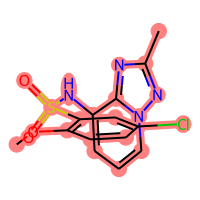
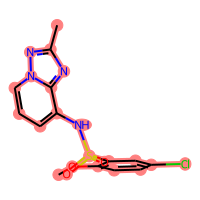
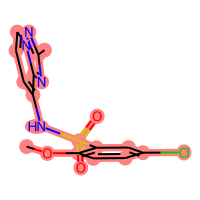
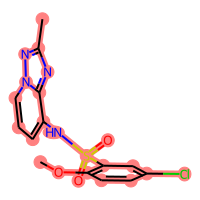
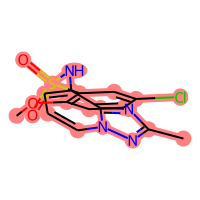
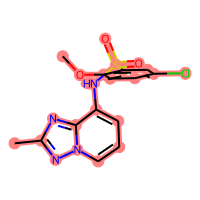
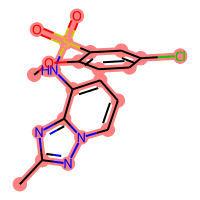
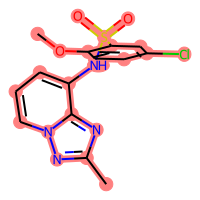
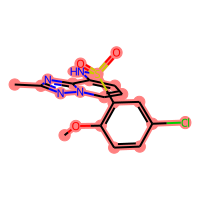

In [190]:
# @title **Show RMSD of ligand pose**
# @markdown This show the **RMSD** of the ligand among 9 other poses. Noted that:
# @markdown + **`RMSD_EL`** = RMSD vs Exp. Lig.
# @markdown + **`RMSD_LB_BP`** = RMSD Lower Bound vs Best Pose
# @markdown + **`RMSD_LB_UP`** = RMSD Upper Bound vs Best Pose
# @markdown + **`cRMSD`** = Consensus RMSD

def get_inplace_rmsd (ref,target):
  r = rdFMCS.FindMCS([ref,target])
  a = ref.GetSubstructMatch(Chem.MolFromSmarts(r.smartsString))
  b = target.GetSubstructMatch(Chem.MolFromSmarts(r.smartsString))   
  amap = list(zip(a,b))
  distances = []
  for atomA,atomB in amap:
    pos_A = ref.GetConformer().GetAtomPosition(atomA)
    pos_B = target.GetConformer().GetAtomPosition(atomB)
    coord_A = np.array((pos_A.x,pos_A.y,pos_A.z))
    coord_B = np.array((pos_B.x,pos_B.y,pos_B.z))
    dist_numpy = np.linalg.norm(coord_A-coord_B)        
    distances.append(dist_numpy)
  rmsd = np.round(math.sqrt(1/len(distances)*sum([i*i for i in distances])),3)
  return rmsd

best_pose = Chem.MolFromMol2File(EXP_mol2_dfile)
best_pose.SetProp("_Name",EXP_pdb[:-4])
best_pose

vina_pose = PandasTools.LoadSDF(LIGAND_out_sdf_dfile)
vina_pose["ID"] = [ LIGAND + "_" + vina_pose.loc[i,"POSE"] for i in vina_pose.index ]
vina_pose["RMSD_EL"] = [ get_inplace_rmsd(best_pose,vina_pose.loc[i,"ROMol"]) for i in vina_pose.index ]
vina_pose["RMSD_EL"] = pd.to_numeric(vina_pose["RMSD_EL"])
vina_pose["RMSD_LB_BP"] = pd.to_numeric(vina_pose["RMSD_LB_BP"])
vina_pose["RMSD_UB_BP"] = pd.to_numeric(vina_pose["RMSD_UB_BP"])
vina_pose["cRMSD"] = np.round((vina_pose["RMSD_EL"] + vina_pose["RMSD_LB_BP"] + vina_pose["RMSD_UB_BP"]) / 3,3)
vina_pose2 = vina_pose[["ID","POSE","SCORE","RMSD_EL","RMSD_LB_BP","RMSD_UB_BP","cRMSD","ROMol"]]
result_xlsx_dfile = os.path.join(docking_folder,"out_result.xlsx")
PandasTools.SaveXlsxFromFrame(vina_pose2,result_xlsx_dfile,molCol="ROMol")
vina_pose2


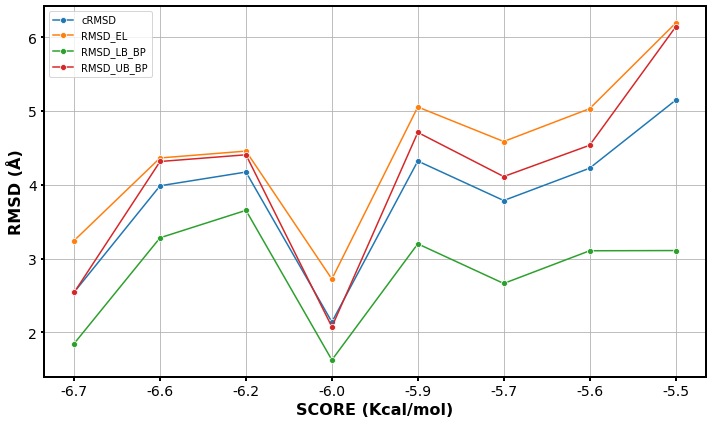

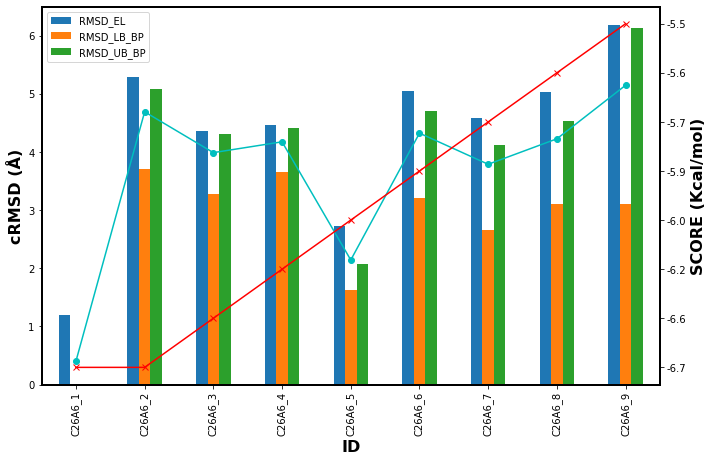

In [183]:
# @title **Show RMSD graph**
# @markdown This show simple graph view of RMSD between each ligand(s) pose.
# RMSD vs SCORE
plt.rcParams["axes.linewidth"] = 2
fig = plt.figure(figsize=(10,6))

ax1 = sns.lineplot(y="cRMSD",x="SCORE",data = vina_pose2,label = "cRMSD", marker = 'o',ci = None)
ax2 = sns.lineplot(y="RMSD_EL",x="SCORE",data = vina_pose2,label = "RMSD_EL", marker = 'o',ci = None)
ax3 = sns.lineplot(y="RMSD_LB_BP",x="SCORE",data = vina_pose2,label = "RMSD_LB_BP", marker = 'o',ci = None)
ax4 = sns.lineplot(y="RMSD_UB_BP",x="SCORE",data = vina_pose2,label = "RMSD_UB_BP", marker = 'o',ci = None)
plt.xlabel('SCORE (Kcal/mol)',fontsize=16,fontweight='bold')
plt.ylabel('RMSD (Å)',fontsize=16,fontweight='bold')

plt.tick_params("both",width = 2,labelsize = 14)
plt.tight_layout()
plt.legend()
plt.grid(True)
plt.show()

# RMSD vs other RMSD vs SCORE 
df = vina_pose2
fig,bx1 = plt.subplots(figsize=(10,6))

bx2 = bx1.twinx()
bx1.plot(df.ID,df.cRMSD,c="c",marker="o")
bx2.plot(df.ID,df.SCORE,c="r",marker="x")
df[["RMSD_EL","RMSD_LB_BP","RMSD_UB_BP"]].plot(ax=bx1,kind="bar")
bx1.set_xlabel("ID",fontsize=16,fontweight='bold')
bx1.set_ylabel('cRMSD (Å)',fontsize=16,fontweight='bold')
bx2.set_ylabel('SCORE (Kcal/mol)',fontsize=16,fontweight='bold')

plt.tight_layout()
plt.xticks(range(9),df.ID)
plt.show()

---
---
# **Save to Google Drive**
Save your docking data in GDrive. 

In [187]:
# @title **Import Google Drive**
# @markdown This allow data to be stored in Google Drive.

# Flush and mount GDrive
with Hide():
  drive.flush_and_unmount()
  drive.mount("/content/drive", force_remount=True)

print("> Mounted at /content/drive")

> Mounted at /content/drive


In [196]:
# @title **Store result in Google Drive**
# @markdown Enter the file destination for saving. The folder will be created if not existed. This save all the files created for molecular docking into Google Drive.

# Define varibles
Destination = "/content/drive/MyDrive/Docking" # @param {type:"string"}
destination_folder = os.path.join(Destination,Jobname)

# Copy file to GDrive
shutil.copytree(work_dir,destination_folder)

print("> Data saved at " + destination_folder)

> Data saved at /content/drive/MyDrive/Docking/7KNX_docking
